## MCX simulation Stage 2.2

In [1]:
! pip install pmcx
! pip install numpy pmcx jdata bjdata matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 1.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for bjdata: filename=bjdata-0.4.1-cp311-cp311-linux_x86_64.whl size=22196 sha256=a4c22a35d17f5c258eddb69ce5c222d9541cc732318acb56b01108d05d69391f
  Stored in directory: /root/.cache/pip/wheels/e4/d5/4a/8d5ccb70c0eb1f07a10da8548e50b7fc0cbdfd014f5eaa45c3
Successfully built bjdata


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
import pmcx

Mounted at /content/drive


In [4]:
# Path to your folder containing the .py script
folder_path = '/content/drive/MyDrive/MCX_data'

# Add to sys.path so you can import the script
if folder_path not in sys.path:
    sys.path.append(folder_path)
from FD_msNIRS import mcx_simulation as ms

In [5]:
pmcx.gpuinfo()

[{'name': 'NVIDIA A100-SXM4-40GB',
  'id': 1,
  'devcount': 1,
  'major': 8,
  'minor': 0,
  'globalmem': 42474471424,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1410000,
  'sm': 108,
  'core': 6912,
  'autoblock': 64,
  'autothread': 442368,
  'maxgate': 0}]

### MCX Simulation using packgae

In [6]:
import pmcx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
from FD_msNIRS import mcx_fft as mf
from FD_msNIRS import extract_freq as ef

In [7]:
g=0.85
wls = [670, 690, 705, 730, 750, 785, 808, 830]
ua = np.array([0.294514, 0.221244, 0.194485 , 0.186506, 0.2238,0.223521,0.234004,0.260758])  # cm-1
us_prime = [15.10252404, 14.40357034,13.91308298,13.15354804,12.59309117,11.70094737,11.16905272,10.69599611] # cm-1
us = np.array([x/(1-g) for x in us_prime])
distance = [2, 2.5, 3, 3.5] # cm

In [8]:
us

array([100.6834936 ,  96.02380227,  92.75388653,  87.69032027,
        83.95394113,  78.0063158 ,  74.46035147,  71.30664073])

In [9]:
# compute ua, distance, and us in mm-1
ua_mm = ua/10
us_mm = us/10
distance_mm = [d*10 for d in distance]

In [10]:
ua_mm

array([0.0294514, 0.0221244, 0.0194485, 0.0186506, 0.02238  , 0.0223521,
       0.0234004, 0.0260758])

In [11]:
us_mm

array([10.06834936,  9.60238023,  9.27538865,  8.76903203,  8.39539411,
        7.80063158,  7.44603515,  7.13066407])

### Run simulations

In [12]:
dictt_ms = {}
for i in range(0, len(distance_mm)):
  d = distance_mm[i]
  print('distance (mm) = ', d)
  for j in range(0, ua_mm.shape[0]):
    print('ua = ', ua_mm[j])
    print('us = ', us_mm[j])
    TPSF, time_unit = ms(ua_mm[j], us_mm[j], g=0.85, n=1.370, distance = d, tend =1e-08, devf = 1000, nphoton = 1.2e8)
    dictt_ms[f'{d}, {wls[j]}'] = [TPSF, time_unit]

distance (mm) =  20
ua =  0.0294514
us =  10.06834936
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua =  0.0221244
us =  9.602380226666664
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua =  0.0194485
us =  9.275388653333334
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua =  0.0186506
us =  8.769032026666666
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua =  0.02238
us =  8.395394113333332
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua =  0.0223521
us =  7.800631579999998
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
m

In [13]:
target_freq = 110e6
uac = []
udc = []
phase1 = []
phase2 = []

for k, v in dictt_ms.items():
    TPSF, tstep = v
    uac_i, udc_i, p1, p2 = ef(target_freq, TPSF, tend=1e-08, devf=1000)
    uac.append(uac_i)
    udc.append(udc_i)
    phase1.append(p1)
    phase2.append(p2)

In [14]:
udc[0]

np.float64(2.0468627470043647e-06)

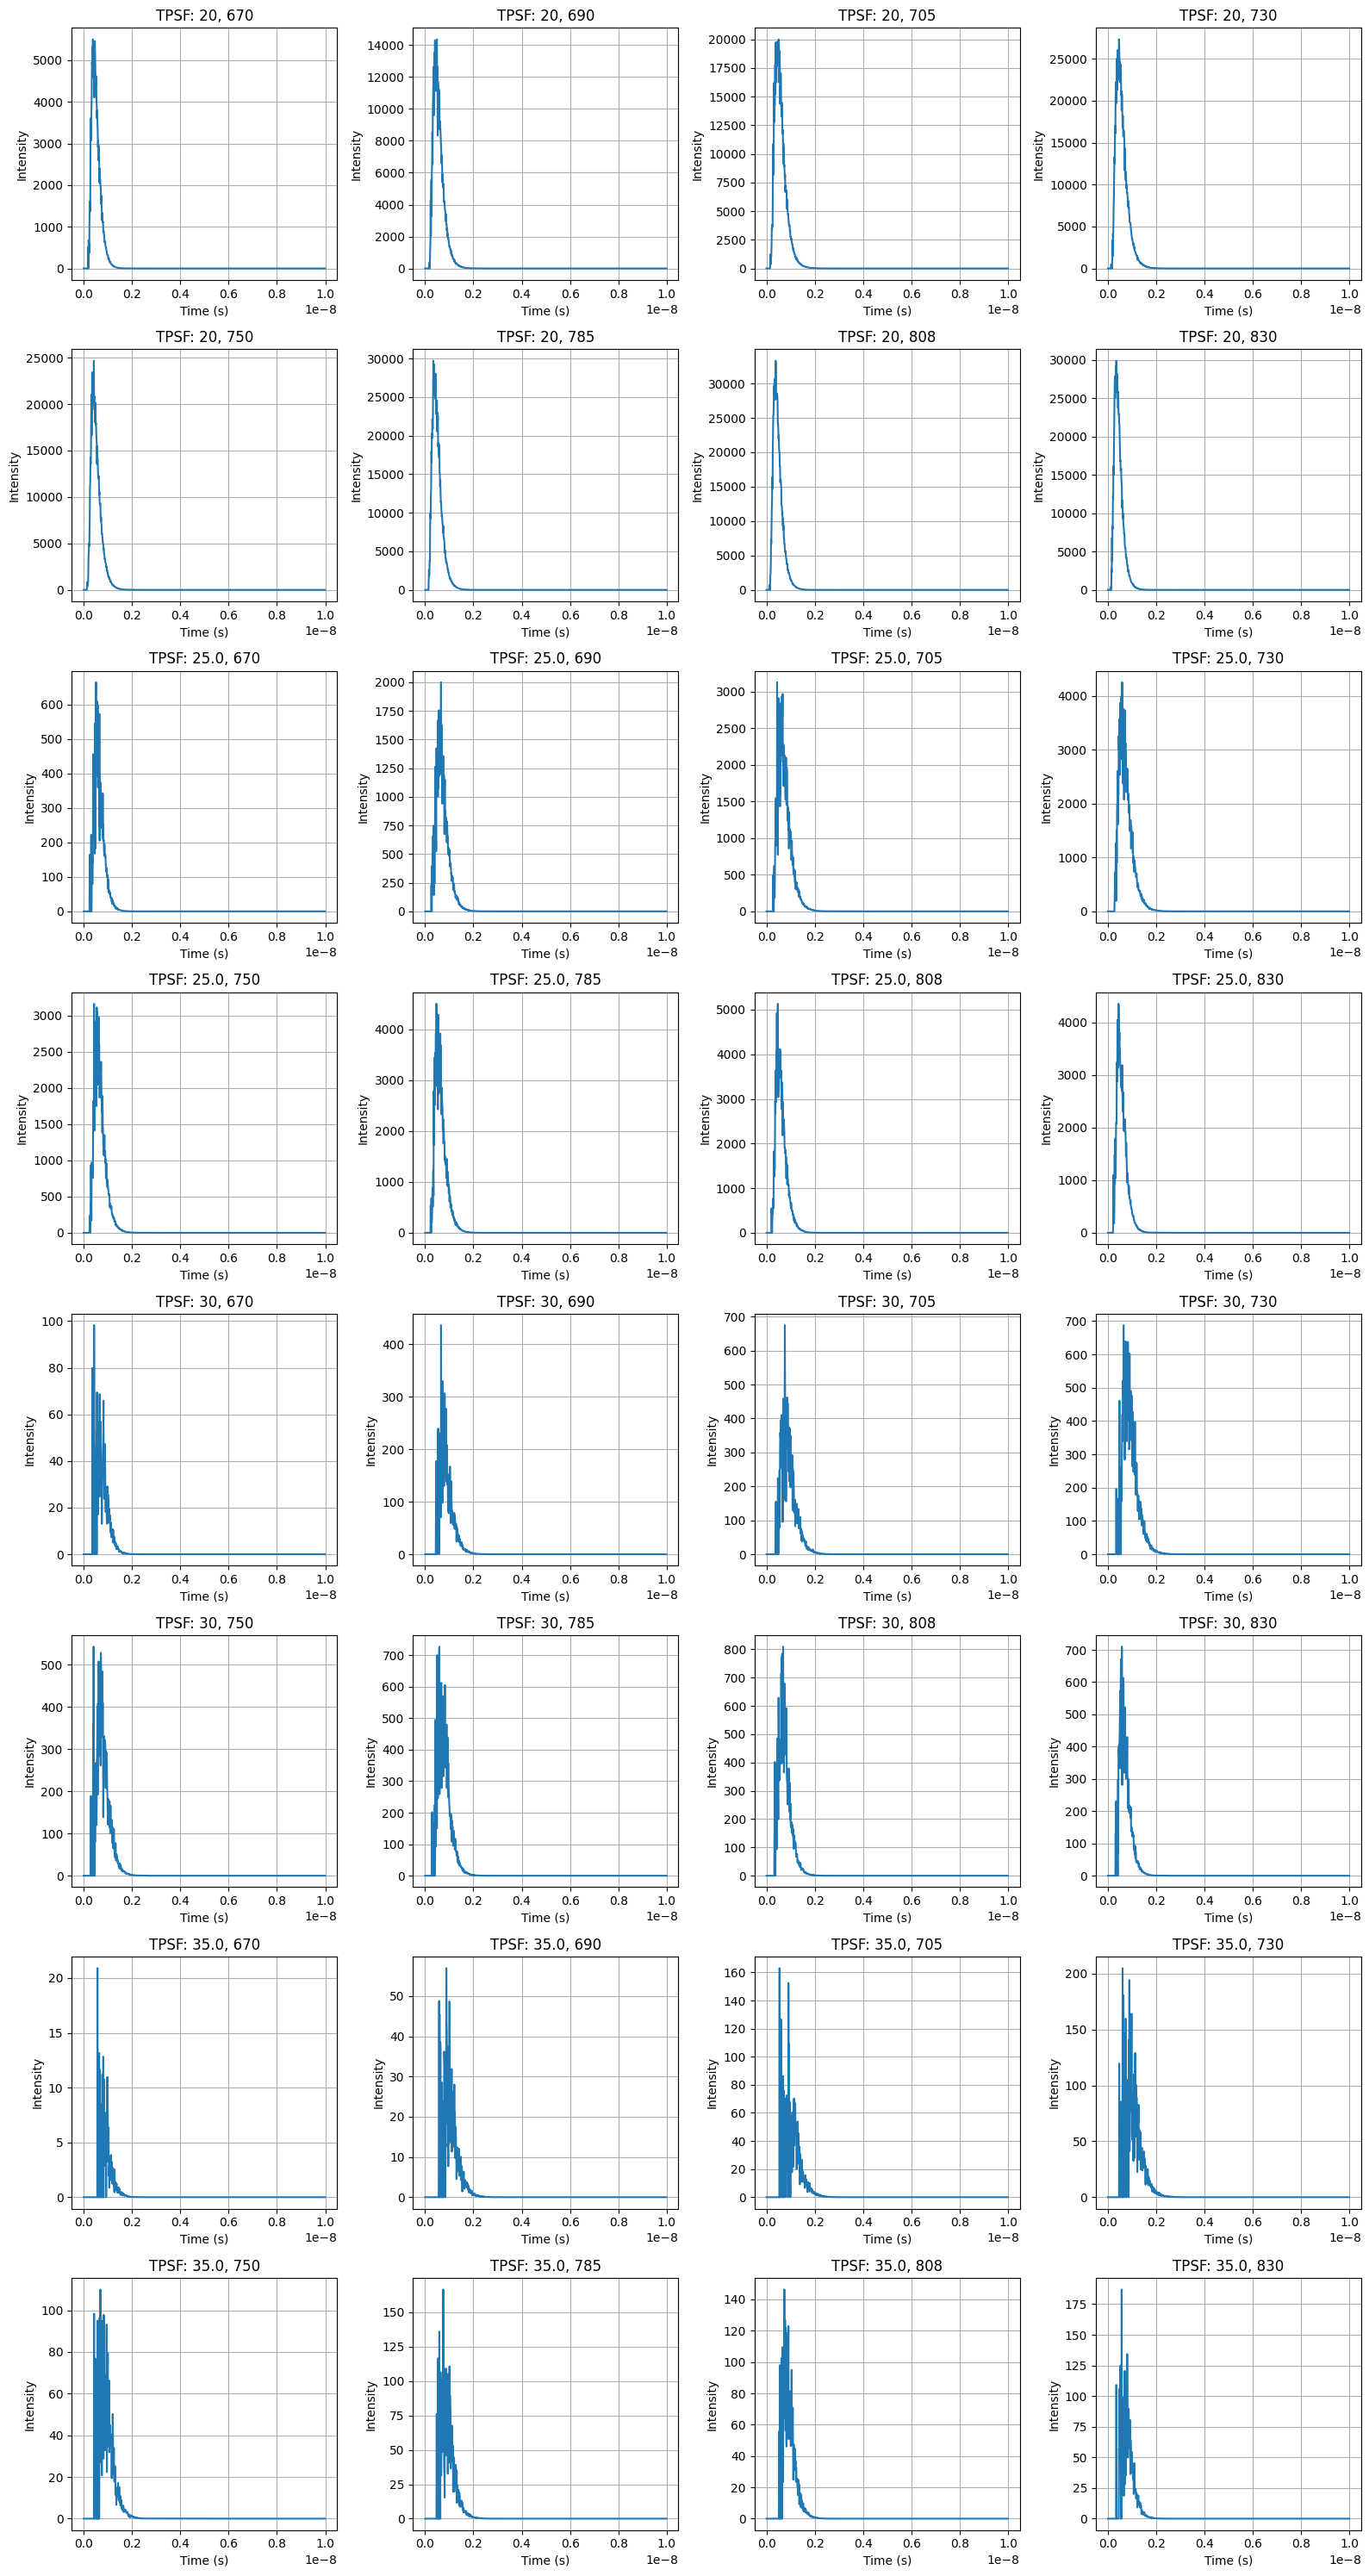

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(8, 4, figsize=(16, 30))  # 8 rows, 4 columns
axes = axes.flatten()  # Flatten for easy indexing

for idx, (label, (TPSF, time_unit)) in enumerate(dictt_ms.items()):

    # Reconstruct time vector
    t = np.arange(len(TPSF)) * time_unit

    # Plot
    axes[idx].plot(t, TPSF)
    axes[idx].set_title(f"TPSF: {label}")
    axes[idx].set_xlabel("Time (s)")
    axes[idx].set_ylabel("Intensity")
    axes[idx].grid(True)

# Remove empty subplots if any
for i in range(len(dictt_ms), 8):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


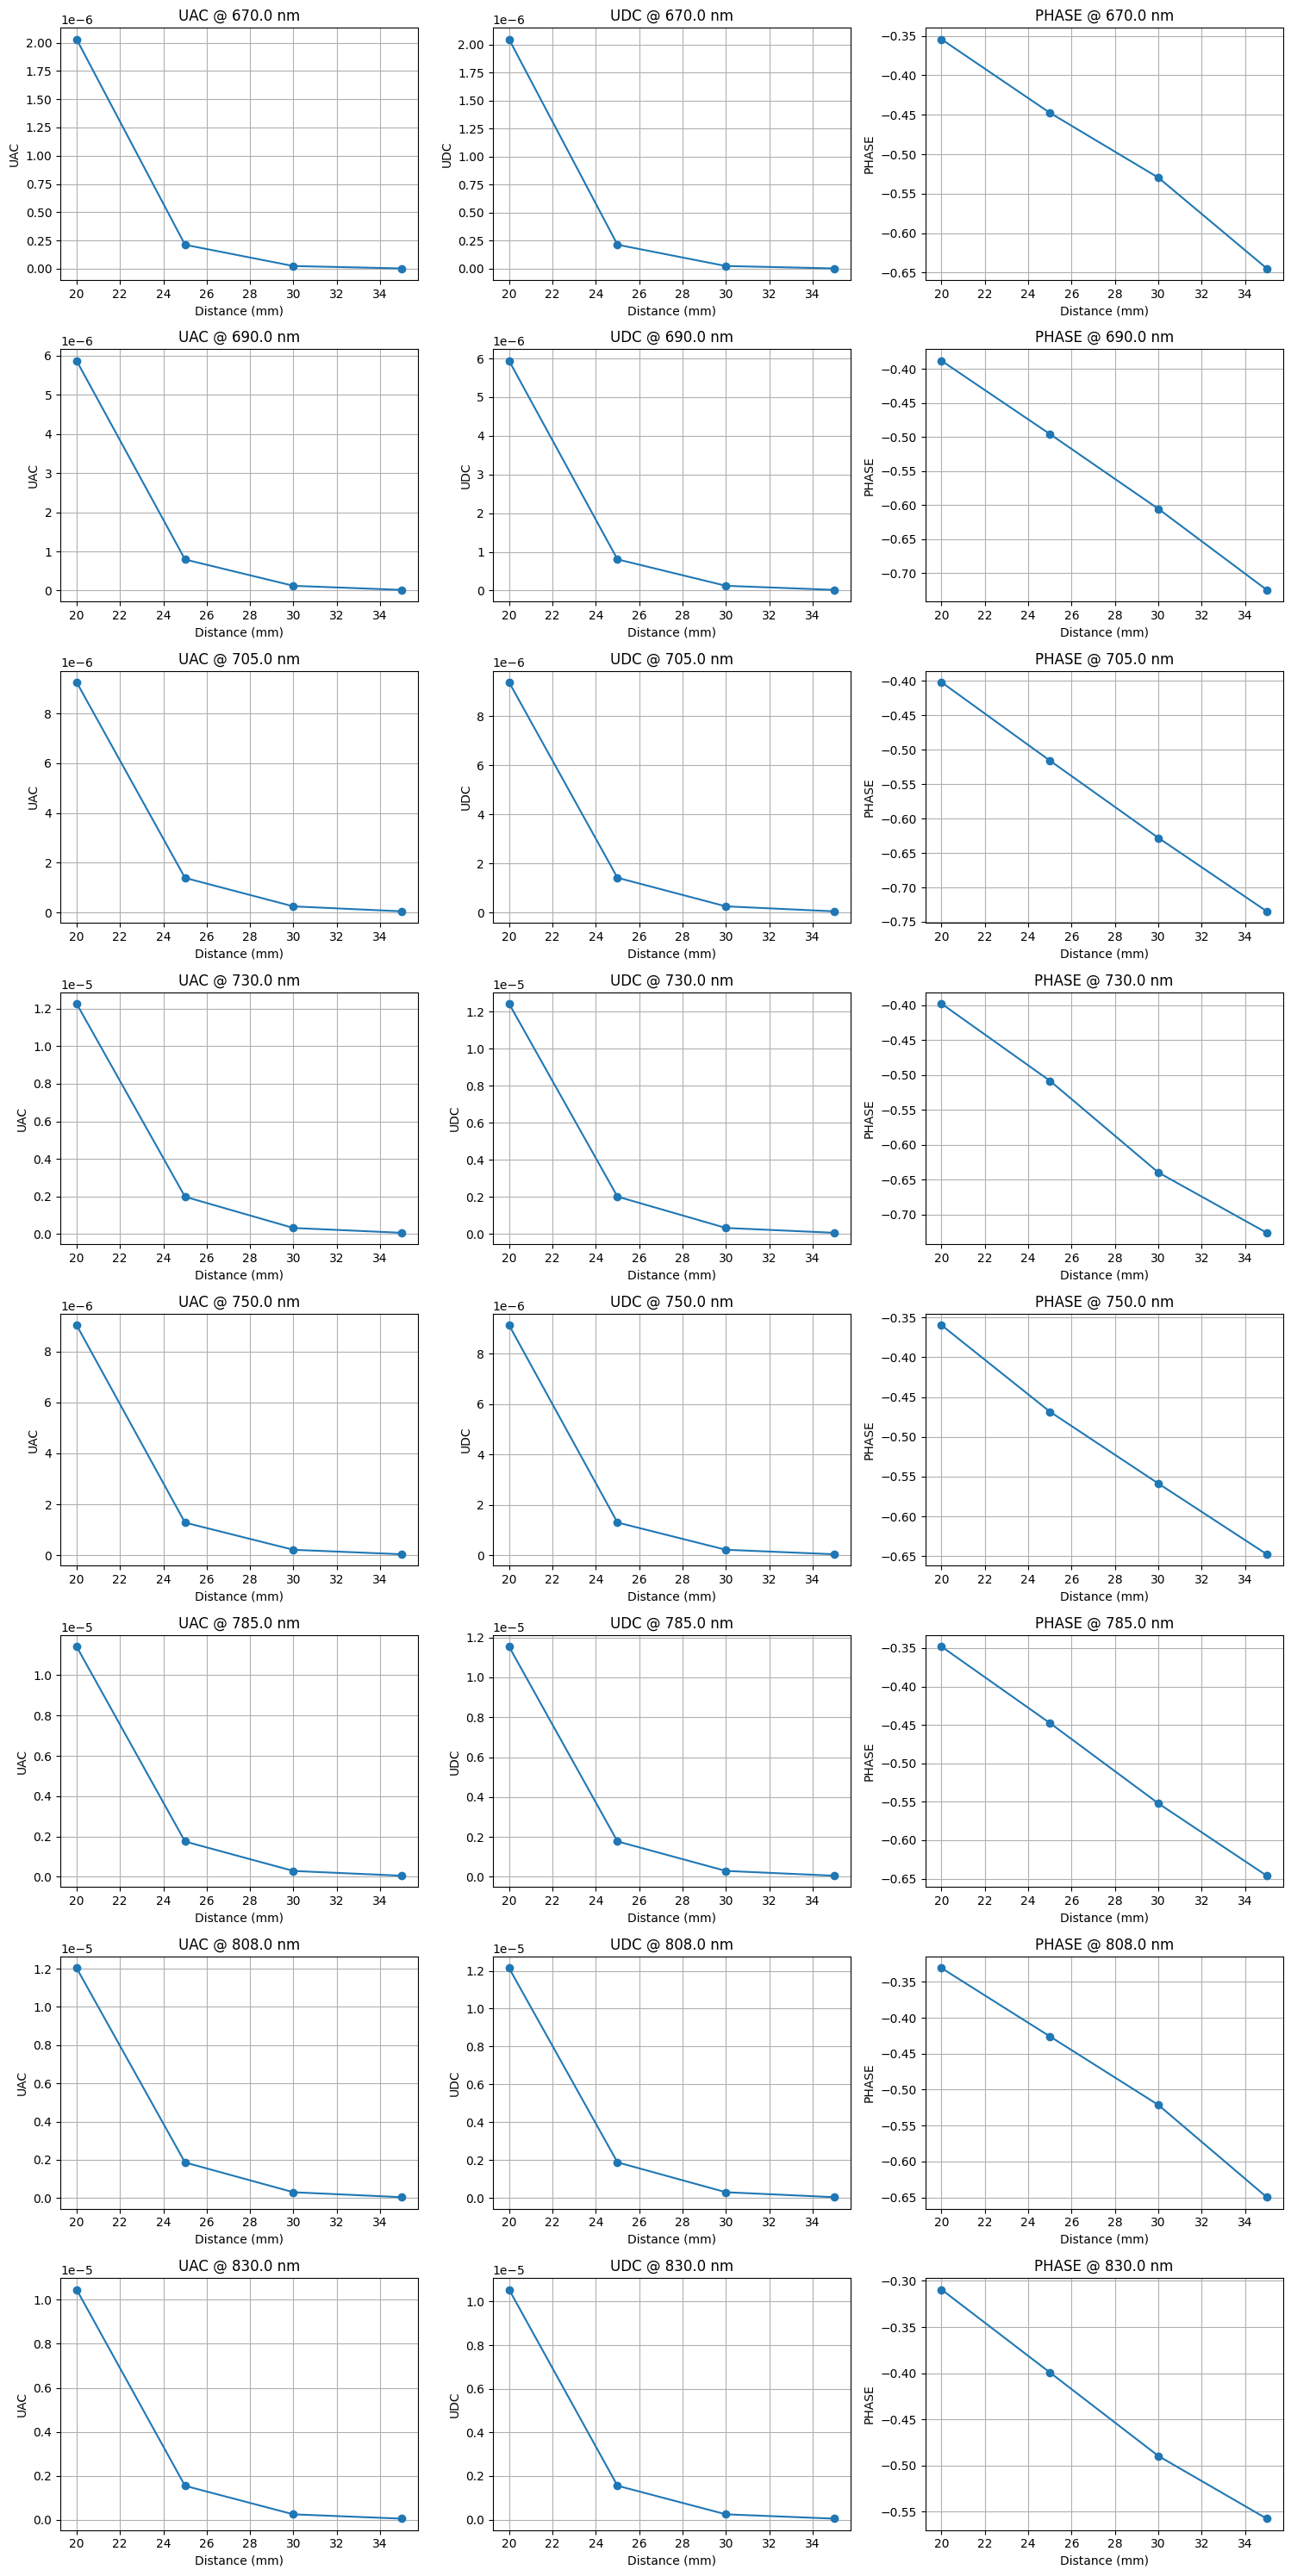

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Group data by wavelength
data_by_wl = {}
for (key, (TPSF, tstep)), uac_i, udc_i, p1, p2 in zip(dictt_ms.items(), uac, udc, phase1, phase2):
    dist_str, wl_str = key.split(',')  # split key: "distance, wavelength"
    wl = float(wl_str.strip())
    d = float(dist_str.strip())

    if wl not in data_by_wl:
        data_by_wl[wl] = {'distance': [], 'uac': [], 'udc': [], 'phase': []}

    data_by_wl[wl]['distance'].append(d)
    data_by_wl[wl]['uac'].append(uac_i)
    data_by_wl[wl]['udc'].append(udc_i)
    data_by_wl[wl]['phase'].append(p1)

# Sort by wavelength
sorted_wls = sorted(data_by_wl.keys())

# Plotting
fig, axes = plt.subplots(8, 3, figsize=(15, 30))
metrics = ['uac', 'udc', 'phase']
titles = ['UAC', 'UDC', 'PHASE']

for row in range(8):
    wl = sorted_wls[row]
    data = data_by_wl[wl]
    distances = data['distance']

    for col in range(3):
        ax = axes[row, col]
        metric = metrics[col]
        ax.plot(distances, data[metric], marker='o')
        ax.set_title(f"{titles[col]} @ {wl} nm")
        ax.set_xlabel("Distance (mm)")
        ax.set_ylabel(titles[col])
        ax.grid(True)

plt.tight_layout()
plt.show()

In [20]:
import pandas as pd
columns = []
row = []
counter = 0
for i in range(len(distance_mm)):
  distance= distance_mm[i]
  for j in range(len(wls)):
    wl = wls[j]
    columns.extend([
        f"U_AC_{i+1}_{j+1}",
        f"U_DC_{i+1}_{j+1}",
        f"Phase_{i+1}_{j+1}"
    ])
    row.extend([uac[counter], udc[counter], phase1[counter]])
    counter = counter + 1

df = pd.DataFrame([row], columns=columns)
df.to_csv("stage3_2_laser.csv", index=False)

In [18]:
phase2

[np.float64(-0.35480583902620855),
 np.float64(-0.38890928360679183),
 np.float64(-0.4027608787565682),
 np.float64(-0.3990332006934715),
 np.float64(-0.3603346096109719),
 np.float64(-0.3487489471780754),
 np.float64(-0.3313106877095258),
 np.float64(-0.3098240333987123),
 np.float64(-0.4481162420535018),
 np.float64(-0.496682843924266),
 np.float64(-0.5171216533480042),
 np.float64(-0.509915608282829),
 np.float64(-0.46927161924925653),
 np.float64(-0.4485087993859099),
 np.float64(-0.4267009335071816),
 np.float64(-0.3998219037767217),
 np.float64(-0.5303172698357136),
 np.float64(-0.6067299363249915),
 np.float64(-0.6297144142393915),
 np.float64(-0.6415242297359982),
 np.float64(-0.55973485599451),
 np.float64(-0.5532050245957609),
 np.float64(-0.5222563869486667),
 np.float64(-0.49038495000394167),
 np.float64(-0.6454983975433495),
 np.float64(-0.7259733552445726),
 np.float64(-0.7367959701128398),
 np.float64(-0.7282798112119735),
 np.float64(-0.6488913076014777),
 np.float64(-0

In [19]:
phase1

[np.float64(-0.35438610222618844),
 np.float64(-0.38812513367573953),
 np.float64(-0.4017335901876228),
 np.float64(-0.3979385581905573),
 np.float64(-0.3596263066961478),
 np.float64(-0.34809029755408255),
 np.float64(-0.330727895083222),
 np.float64(-0.30938836655178203),
 np.float64(-0.4475743184309983),
 np.float64(-0.4956622626774879),
 np.float64(-0.5157318801789975),
 np.float64(-0.5084050396891946),
 np.float64(-0.4683587820423888),
 np.float64(-0.44759890663616936),
 np.float64(-0.4259143107082567),
 np.float64(-0.3992309822630692),
 np.float64(-0.5296669434952344),
 np.float64(-0.6054255068095993),
 np.float64(-0.6279634177249483),
 np.float64(-0.6397402407741524),
 np.float64(-0.5586087650265602),
 np.float64(-0.5521272674065656),
 np.float64(-0.5212965436118941),
 np.float64(-0.4896222122524779),
 np.float64(-0.64470230514396),
 np.float64(-0.7243132045090179),
 np.float64(-0.734789464274138),
 np.float64(-0.7261381220702694),
 np.float64(-0.647485216282527),
 np.float64(-0